In [1]:
'''Import all necessary library files'''
from collections import Counter
import glob
import hashlib
import io
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import string
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cross_validation import train_test_split
from nltk.classify.scikitlearn import SklearnClassifier
import pandas as pd
%matplotlib inline
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
import metacritic
import pickle
import pandas as pd
import shutil

In [2]:
df = pd.read_csv("reviews.txt",sep='\t')
df.head()

,﻿Review,Sentiment
0,That such intelligence could be contained in a...,100
1,Shines with a kind of inspired madness.,100
2,Here is the most passionate and tender love st...,100
3,"One of the greatest of all American films, but...",100
4,A remarkable film.,100


In [3]:
df.tail()

,﻿Review,Sentiment
44004,The lack of imagination in Stargate is distres...,25
44005,"Oz the Great and Powerful is an oppressive, bl...",25
44006,"It is a grand-looking, grandly empty pageant.",25
44007,There’s exactly one good scene in all of The H...,25
44008,Man on a Ledge just made me think of an old Va...,25


In [4]:
df.describe()

,Sentiment
count,43909.000000
mean,62.551140
std,22.785175
min,0.000000
25%,50.000000
50%,63.000000
75%,80.000000
max,100.000000


**Data split into positive and negative:**

We split our dataset by considering the reviews with scores above 65 to be Positive and those ones that are below 65 to be considered as negative and store them into two separate dataframes.

In [5]:
#split positive and negative reviews based on scores 
pos = df[df.Sentiment > 65]
neg = df[df.Sentiment < 65]
pos.describe()

,Sentiment
count,21027.000000
mean,81.959623
std,9.922689
min,67.000000
25%,75.000000
50%,80.000000
75%,90.000000
max,100.000000


In [6]:
neg.describe()

,Sentiment
count,22843.000000
mean,44.681434
std,15.531329
min,0.000000
25%,38.000000
50%,50.000000
75%,60.000000
max,63.000000


In [7]:
'''Drop the Sentiment column from the dataframe'''
pos = pos.drop('Sentiment', 1)
neg = neg.drop('Sentiment',1)

In [9]:
'''Create a folder called data-MNB in your working directory along with pos and neg sub folders present
in both train and test folders. After creation navigate using cd command to the pos sub-folder under train. '''

cd C:\Users\Praveen\Desktop\CS-579-Project\data-MNB\train\pos

C:\Users\Praveen\Desktop\CS-579-Project\data-MNB\train\pos


In [10]:
'''Storing each review from the positive dataframe into the positive sub-folder'''
i=1
for index, row in pos.iterrows():
    if i > len(pos):
        break
    else:
        f = open(str(i)+'.txt', 'w')
        f.write(row[0])
        f.close()
        i+=1

In [11]:
'''Navigate using cd command to the neg sub-folder under train'''
cd C:\Users\Praveen\Desktop\CS-579-Project\data-MNB\train\neg

C:\Users\Praveen\Desktop\CS-579-Project\data-MNB\train\neg


In [12]:
'''Storing each review from the negative dataframe into the negative sub-folder as indepedant text files'''
i=1
for index, row in neg.iterrows():
    if i > len(neg):
        break
    else:
        f = open(str(i)+'.txt', 'w')
        f.write(row[0])
        f.close()
        i+=1

In [15]:
'''Back up again to your working directory using triple cd '''
cd ..

C:\Users\Praveen\Desktop\CS-579-Project


In [16]:
'''Setting path and listing out the sub-directories in the specified path'''

path = 'data-MNB'
print('subdirectories are:' + str(os.listdir(path)))

subdirectories are:['test', 'train']


In [17]:
def get_files(path):
    """ Return a list of file names in this directory that end in .txt 
    The list should be sorted alphabetically by file name.
    Params:
        path....a directory containing .txt review files.
    Returns:
        a list of .txt file names, sorted alphabetically.
    """
    files = os.listdir(path)
    res=[]
    for f in files:
        if f.endswith('.txt'):
                res.append((path + os.sep + f))
    return sorted(res)

In [18]:
'''Print the length of positive and negative files before splitting test data'''
pos_train = get_files(path + os.sep + 'train' + os.sep + 'pos')
neg_train = get_files(path + os.sep + 'train' + os.sep + 'neg')
all_train = pos_train + neg_train
print len(pos_train)
print len(neg_train)

21027
22843


In [19]:
'''Split testing data from the whole dataset'''
for i in range(18001,len(pos_train)+1): 
    shutil.move("data-MNB/train/pos/" + str(i)+'.txt', "data-MNB/test/pos/" + str(i)+'.txt')
for i in range(18001,len(neg_train)+1):
    shutil.move("data-MNB/train/neg/" + str(i)+'.txt', "data-MNB/test/neg/" + str(i)+'.txt')

In [20]:
'''Print the length of positive and negative training files after splitting test data'''
pos_train_files = get_files(path + os.sep + 'train' + os.sep + 'pos')
neg_train_files = get_files(path + os.sep + 'train' + os.sep + 'neg')
all_train_files = pos_train_files + neg_train_files
print len(pos_train_files)
print len(neg_train_files)

18000
18000


In [21]:
print('found %d positive and %d negative training files' %
      (len(pos_train_files), len(neg_train_files)))
print('first positive file: %s' % pos_train_files[0])
print('first negative file: %s' % neg_train_files[0])

found 18000 positive and 18000 negative training files
first positive file: data-MNB\train\pos\1.txt
first negative file: data-MNB\train\neg\1.txt


## Sentiment Analysis

We will now use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is positive or negative, depending on the text of the review. 

Most models work with numerical data, so we need to convert the textual collection of reviews to something numerical. A common strategy for text classification is to represent each review as a "bag of words" vector -- a long vector
of numbers encoding how many times a particular word appears in a blurb.

We will use the Scikit-learn object called a `CountVectorizer` which turns text into a bag of words.

In [22]:
def get_true_labels(file_names):
    """Return a *numpy array* of ints for the true sentiment labels of each file.
    1 means positive, 0 means negative. Use the name of the file to determine
    the true label.
    Params:
        file_names....a list of .txt file paths, e.g., data/train/pos/10057_9.txt
    Returns:
        a numpy array of 1 or 0 values corresponding to each element
        of file_names, where 1 indicates a positive review, and 0
        indicates a negative review.
    """
    x=np.ones((len(file_names[:(len(file_names)/2)]),), dtype=np.int)
    y=np.zeros((len(file_names[(len(file_names)/2):]),), dtype=np.int)
    z=np.concatenate([x, y])
    return z

In [23]:
labels = get_true_labels(all_train_files)
print('first 3 and last 3 labels are: %s' % str(labels[[1,2,3,-3,-2,-1]]))

first 3 and last 3 labels are: [1 1 1 0 0 0]


In [24]:
def file2string(filename):
    return io.open(filename,encoding='utf8').readlines()[0]
   
file2string(pos_train_files[10])

u"Coppola brilliantly conjures the young queen's insular world, in which she was both isolated and claustrophobically scrutinized."

In [25]:
def tokenize(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is removed. Note that
    underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    x=re.findall(r'\w+',text.lower())
    return x

In [26]:
def do_vectorize(filenames, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
    vectorizer = CountVectorizer(input='filename',tokenizer=tokenizer_fn,min_df=min_df,
                 max_df=max_df, binary=binary, ngram_range=ngram_range,dtype=int)
    dtm = vectorizer.fit_transform(filenames)
    
    return (dtm,vectorizer)
    
matrix,vec = do_vectorize(all_train_files)

print ('matrix represents %d documents with %d features' % (matrix.shape[0], matrix.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrix[0].nonzero()[1]))))

matrix represents 36000 documents with 37810 features
first doc has terms:
[398, 1485, 2932, 6992, 7317, 10948, 13300, 16539, 17144, 17504, 18345, 21311, 21890, 23100, 30245, 30854, 30981, 32375, 33485]


In [27]:
# Do not modify. This is to randomize the order of the documents, but
# in a way that is consistent across platforms.
# You should run this block once to get the shuffled data.
def repeatable_random(seed):
    hash = str(seed)
    while True:
        hash = hashlib.md5(hash).digest()
        for c in hash:
            yield ord(c)

def repeatable_shuffle(X, y, filenames):
    r = repeatable_random(42) 
    indices = sorted(range(X.shape[0]), key=lambda x: next(r))
    return X[indices], y[indices], np.array(filenames)[indices]

X, y, filenames = repeatable_shuffle(matrix, labels, all_train_files)

print('first shuffled document %s has label %d and terms: %s' % 
      (filenames[0], y[0], sorted(X[0].nonzero()[1])))

first shuffled document data-MNB\train\pos\10103.txt has label 1 and terms: [1442, 1697, 1911, 2049, 2651, 2932, 3106, 5917, 9820, 10213, 10502, 10577, 12545, 12805, 15577, 15968, 17565, 19152, 19277, 21918, 22362, 22628, 29313, 29580, 30008, 30854, 33901]


**Multinomial Naive Bayes - Synopsis**

Multinomial Naive Bayes is used when the multiple occurrences of the words matter a lot in the classification problem. It is a specialized version of Naive Bayes that is designed more for text documents. This model explicitly models the word counts and adjusts the underlying calculations to deal with in. Basically our goal here is to determine whether a particular movie review is positive or negative. But in general reviews are just some bunch of words, so the first step inorder to train a multinomial Naive Bayes model to classify reviews to either to be positive or negative is to collect all the movie reviews that are pre-classified to be either positive or negative. Now we make two separate lists. The first list consists of  all the words that have appeared in our positive reviews along with the number of times they have appeared and the second list consists of all the words that have appeared in our negative reviews along with the number of times they have appeared. Now using these list we can estimate the probability of a particular word appearing in a positive review or in a negative review as represented by the formula given below.
<img src="mnb.png"width=700>

In [28]:
'''Method to get the Multinomial naive bayes classifier'''
def get_clf_Mnb():
    return MultinomialNB()

In [29]:
#Multinomial Naive Bayes Classifier
def do_cross_validation(X, y, n_folds=5, verbose=False):
    """
    Perform n-fold cross validation, calling get_clf() to train n
    different classifiers. Use sklearn's KFold class: http://goo.gl/wmyFhi
    Be sure not to shuffle the data, otherwise your output will differ.
    Params:
        X.........a csr_matrix of feature vectors
        y.........the true labels of each document
        n_folds...the number of folds of cross-validation to do
        verbose...If true, report the testing accuracy for each fold.
    Return:
        the average testing accuracy across all folds.
    """
    cv = KFold(len(y), n_folds)
    acc = []
    n=0
    for train_idx, test_idx in cv:
        clf = get_clf_Mnb()
        clf.fit(X[train_idx], y[train_idx])
        predicted = clf.predict(X[test_idx])
        accuracy = accuracy_score(y[test_idx], predicted)
        acc.append(accuracy)
        if verbose:
            print 'fold %d accuracy=%.4f' % (n,accuracy)
        n=n+1
    avg = np.mean(acc)
    return avg
    
print('average cross validation accuracy using multinomial naive bayes classifier=%.4f' %
      do_cross_validation(X, y, verbose=True))

fold 0 accuracy=0.7562
fold 1 accuracy=0.7650
fold 2 accuracy=0.7585
fold 3 accuracy=0.7500
fold 4 accuracy=0.7543
average cross validation accuracy using multinomial naive bayes classifier=0.7568


In [30]:
def do_expt(filenames, y, tokenizer_fn=tokenize,
            min_df=1, max_df=1., binary=True,
            ngram_range=(1,1), n_folds=5):
    """
    Run one experiment, which consists of vectorizing each file,
    performing cross-validation, and returning the average accuracy.
    You should call do_vectorize and do_cross_validation here.
    Params:
        filenames.......list of review file names
        y...............the true sentiment labels for each file
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
        n_folds.........The number of cross-validation folds to use.
    Returns:
        the average cross validation testing accuracy.
    """
    m,vec = do_vectorize(filenames,binary=binary,tokenizer_fn=tokenizer_fn,min_df=min_df,max_df=max_df)
    res=(do_cross_validation(m,y,n_folds=n_folds))
    #avg = np.mean(res)

    return res

In [31]:
print('accuracy using multinomial naive bayes classifier with default settings: %.4g' % do_expt(filenames, y))

accuracy using multinomial naive bayes classifier with default settings: 0.7568


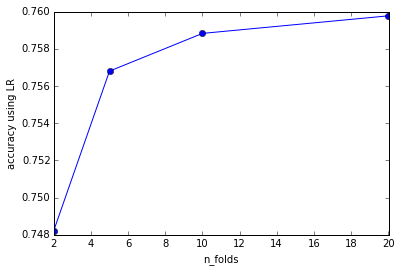

[0.74822222222222223,
 0.75680555555555562,
 0.75883333333333336,
 0.75977777777777766]

In [32]:
def compare_n_folds(filenames, y):
    """
    Vary the setting of n_folds parameter in the do_expt 
    function to be in [2,5,10,20]. For each setting, call do_expt and 
    store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per fold.
    """
    fold=[2,5,10,20]
    avg_acc=[]
    for f in fold:
        avg_acc.append(do_expt(filenames,y,n_folds=f))
        
    plt.xlabel('n_folds')
    plt.ylabel('accuracy using LR')
    plt.plot(fold,avg_acc,'bo-')
    plt.show()
    
    return avg_acc
    
compare_n_folds(filenames, y)

**Graph Inference**

We can see from the above picture that as the number of folds increases for a fixed amount of data, number of data within each fold decreases. Which basically means that there is less data that is available for testing. Also, more data is available for training purposes. Therefore, effect of increasing number of folds does increse the classifier's accuracy It trains the model more and tests the model with less data per fold. Hence, accuracy increases.

In [33]:
def compare_binary(filenames, y):
    """
    How does the binary parameter affect results? 
    Call do_expt twice, once with binary=True, and once with binary=False.
    Return the average accuracies for each. Use the default parameters for the
    remaining arguments in do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies. The first entry
        is for binary=True, the second is for binary=False.
    """
    avg=[]
    avg.append(do_expt(filenames,y,binary=True))
    avg.append(do_expt(filenames,y,binary=False))
    return avg

compare_binary(filenames, y)

[0.75680555555555562, 0.75538888888888889]

In [34]:
def tokenize_with_punct(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is kept as separate tokens.
    Note that underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    y=re.sub(r'[\n\r\x85]', ' ', text.lower())
    x=re.findall(r"[\w]+|[\S]", y.lower())
    return x

In [35]:
def tokenize_with_not(text):
    """Does the same thing as tokenize_with_punct, with the following difference:
    whenever the term 'not' appears, change the two subsequent tokens to have the prefix
    'not_' prior to the token. See the example below. You may call 
    tokenize_with_punct as a subroutine.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    res= []
    
    k=0
    for token in tokenize_with_punct(text):
        if token == 'not':
            k=2
            res.append(token)
        else:
            if k>0:
                join = 'not_' + token
                res.append(join)
                k = k-1
            else:
                res.append(token)

    return res

In [36]:
def tokenizer_expt(all_train_files, y):
    """
    How does the tokenizer affect results? 
    Call do_expt three times, using three different tokenizers:
    1- tokenize
    2- tokenize_with_punct
    3- tokenize_with_not
    Return the average cross-validation accuracy for each approach,
    in the above order. Use the default parameters for all other 
    arguments to do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies for each tokenizer.
    """
    avg=[]
    avg.append(do_expt(all_train_files,y,tokenizer_fn=tokenize))
    avg.append(do_expt(all_train_files,y,tokenizer_fn=tokenize_with_punct))
    avg.append(do_expt(all_train_files,y,tokenizer_fn=tokenize_with_not))
    return avg

tokenizer_expt(filenames, y)

[0.75680555555555562, 0.75663888888888875, 0.75855555555555554]

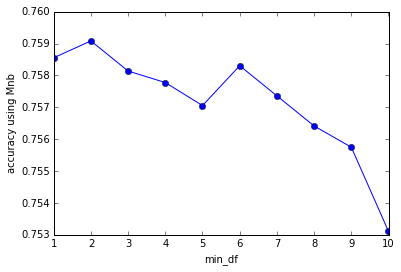

[0.75855555555555554,
 0.75908333333333333,
 0.75813888888888881,
 0.75777777777777788,
 0.75705555555555548,
 0.75830555555555557,
 0.75736111111111115,
 0.75641666666666663,
 0.75575000000000003,
 0.75311111111111106]

In [37]:
def min_df_expt(filenames, y):
    """
    Vary the setting of min_df parameter in the do_expt 
    function to be ints in the range (1,10) (inclusive). For each setting,
    call do_expt and store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function, except that the tokenizer
    should be tokenize_with_not.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per min_df value.
    """
    avg=[]
    for i in range(1,11):
        avg.append(do_expt(filenames,y,tokenizer_fn=tokenize_with_not,min_df=i,max_df=1., binary=True, ngram_range=(1,1)))
    #plt.plot(avg,color='b')
    plt.xlabel('min_df')
    plt.ylabel('accuracy using Mnb')
    plt.plot(range(1,11),avg,'bo-')
    plt.show()
    return avg

min_df_expt(filenames, y)

**Decline in accuracy**

The min_df parameter refers particularly to the cut-off value for ignoring terms that have lower document frequency than the mentioned value. Setting a too low value will ignore very rare terms which doesn't count towards sentiment calculation. A bit higher value will ignore sufficient rare terms which will improve accuracy. If the value is high, the model will ignore necessary terms as well and that's why we observe a decline in accuracy in the right hand side of the above graph.

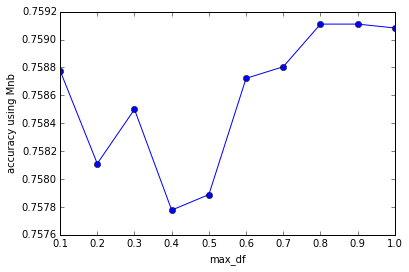

[0.75877777777777777,
 0.75811111111111118,
 0.75849999999999995,
 0.75777777777777777,
 0.75788888888888883,
 0.75872222222222219,
 0.75880555555555551,
 0.75911111111111107,
 0.75911111111111107,
 0.75908333333333333]

In [38]:
def max_df_expt(filenames, y):
    """
    Vary the setting of max_df parameter in the do_expt 
    function to be one of [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.].
    For each setting, call do_expt and store the resulting accuracy.
    Plot the accuracies for each setting. Also return the list of accuracies.
    Use the default value for all other arguments to the do_expt function,
    except that the tokenizer=tokenize_with_not and min_df=2.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per max_df value.
    """
    avg=[]
    max = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]
    for i in max:
        avg.append(do_expt(filenames,y,tokenizer_fn=tokenize_with_not,min_df=2,max_df=i, binary=True, ngram_range=(1,1)))
    
    plt.xlabel('max_df')
    plt.ylabel('accuracy using Mnb')
    plt.plot(max,avg,'bo-')
    plt.show()
    return avg
    
max_df_expt(filenames, y)

In [41]:
X, vec = do_vectorize(filenames, tokenizer_fn=tokenize_with_not,
                      binary=True, min_df=2, max_df=.7)

'''Splitting train and test data within the test data to measure our performance'''

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = get_clf_Mnb()
#clf.fit(X, y)
clf.fit(X_train, Y_train)
print 'Multinomial Naive Bayes classifier accuracy for training data:', round(clf.score(X_train, Y_train), 3)
print 'Multinomial Naive Bayes classifier accuracy for test data:', round(clf.score(X_test, Y_test),3)

Multinomial Naive Bayes classifier accuracy for training data: 0.871
Multinomial Naive Bayes classifier accuracy for test data: 0.753


We can see from above train and test split within the training data, there's seems to be some overfitting happening here, since the error rate on the test data (25%) is almost twice as large as the error rate on the training data (13%). It's possible (though unlikely) that the accuracy difference is a product of chance, and not a symptom of overfitting. This could be tested with cross-validation, by repeatedly fitting and scoring the classifier on different train/test splits. If the performance on the training data is consistently better than the test data, then overfitting has occured. This is the case here.

In [48]:
#calculate testing accuracy again by generating vocabulary on reviews present in the test folder. 
#Here we again use the Multinomial classifier at first to predict the accuracy on test data.
pos_test_files = get_files(path + os.sep + 'test' + os.sep + 'pos')
neg_test_files = get_files(path + os.sep + 'test' + os.sep + 'neg')
all_test_files = pos_test_files + neg_test_files
# Note that we call .transform, not .fit_transform, since we 
# don't want to learn a new vocabulary.
clf = get_clf_Mnb()
X_test = vec.transform(all_test_files)
y_test = np.array([1] * len(pos_test_files) + [0] * len(neg_test_files))
clf.fit(X_test,y_test)
print('X_test represents %d documents with %d features' % (X_test.shape[0], X_test.shape[1]))
print('y_test has %d positive and %d negative labels' % (len(np.where(y_test==1)[0]),
                                                          len(np.where(y_test==0)[0])))
print('first testing file is %s' % all_test_files[0])
print('last testing file is %s' % all_test_files[-1])
print('testing accuracy using Multinomial classifier=%.4g' % accuracy_score(y_test, clf.predict(X_test)))

X_test represents 7870 documents with 24221 features
y_test has 3027 positive and 4843 negative labels
first testing file is data-MNB\test\pos\18001.txt
last testing file is data-MNB\test\neg\22843.txt
testing accuracy using Multinomial classifier=0.9086


**Model Calibration**

Bayesian models like the Naive Bayes classifier have the nice property that they compute probabilities of a particular classification -- the `predict_proba` and `predict_log_proba` methods of `MultinomialNB` compute these probabilities. 

We should always assess whether these probabilities are **calibrated** -- that is, whether a prediction made with a confidence of `x%` is correct approximately `x%` of the time.

Let's make a plot to assess model calibration. By googling we found calibration plots like the one below where they've used two classifiers, Logit and a naive bayes model.

<img src="http://scikit-learn.org/stable/_images/plot_calibration_curve_0011.png" width=500px>

In words, we want to:

Take a collection of examples, and compute the positive probability for each using `clf.predict_proba` and then gather examples into bins of similar positive probability. For each bin, we then count the number of examples in that bin, and compute the fraction of examples in the bin which are positive. In the upper plot, we graph the expected P(pos) (x axis) and observed positive fraction (Y axis). After which we Estimate the uncertainty in observed positive fraction $F$ via the [equation](http://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) $\sigma = \sqrt{F (1-F) / N}$. Finally we overplot the line y=x. This is the trend we would expect if the model is calibrated. In the lower plot, we show the number of examples in each bin.


In [43]:
from math import sqrt
"""
Function
--------
calibration_plot

Builds a plot like the one above, from a classifier and review data

Inputs
-------
clf : Classifier object
    A MultinomialNB classifier
X : (Nexample, Nfeature) array
    The bag-of-words data
Y : (Nexample) integer array
    1 if a review is positive
"""    
def calibration_plot(clf, X, Y):
    
    # split up data into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    # train classifier
    clf.fit(X_train, Y_train)
    
    print 'Classifier accuracy for training data: '+str(round(clf.score(X_train, Y_train), 3))
    print 'Classifier accuracy for test data: '+str(round(clf.score(X_test, Y_test),3))
    
    # the rest is old (y-)hat.
    neg, pos = zip(*clf.predict_proba(X_train))

    bins = np.linspace(0,1,20)
    bin_places = np.digitize(pos, bins)
            
    prob_df = pd.DataFrame({'xtrain_prob':pos, 'ytrain':Y_train, 'bin_place':bin_places})
    
    grouped_df = prob_df.groupby('bin_place')
    positive = grouped_df['ytrain']
    
    p_result = []
    p_sigmas = []
    bin_totals = grouped_df.size().values
    
    for c, val in positive:
        
        fsum = np.sum(val.values.astype(int))
        
        p_res = round(float(fsum)/float(bin_totals[c-1]), 3)
        
        p_result.append(p_res)
        pos_sigma = sqrt(p_res*(1-p_res)/bin_totals[c-1])
        p_sigmas.append(pos_sigma)
        
    fig = plt.figure()
    
    ax_top = fig.add_subplot(2,1,1)
    ax_top.plot(bins[1:20], p_result)
    ax_top.errorbar(bins[1:20], p_result, yerr=p_sigmas, fmt='ro')
    
    ax_top.plot(p_result, p_result, c='r')
    ax_top.set_xticks(np.arange(0,1.1,.05))
    ax_top.set_xticklabels(np.arange(0,1.1,.05), rotation='vertical')
    ax_top.set_yticks(np.arange(0,1.2,.1))
    ax_bot = fig.add_subplot(2,1,2)
    ax_bot.bar(range(len(bin_totals)), bin_totals, .5)
    
    ax_bot.set_xticks(range(19))
    
    plt.subplots_adjust(top=1.5)
    plt.subplots_adjust(bottom=.5)

Classifier accuracy for training data: 0.871
Classifier accuracy for test data: 0.753


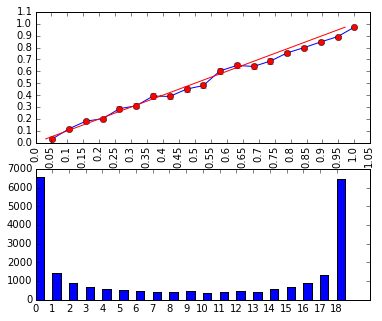

In [50]:
'''Calibration plot for estimated for tain and test data split from the entire training data'''
calibration_plot(clf, X, y)

**Calibration inference**

We might say a model is over-confident if the positive fraction is usually closer to 0.5 than expected (that is, there is more uncertainty than the model predicted). Likewise, a model is under-confident if the probabilities are usually further away from 0.5. We can infer from the above calibrated graph, for most part the model is under-confident - the actual positive fraction lags a bit behind expectations. For example, between the expected 35-40% bins, our y-axis (pos_frac) is only at about 25%. 
It starts getting better around 0.55, however, and by the highest quartile or so it performs quite nicely.

In [45]:
features = vec.get_feature_names()
eyematrix = np.eye(len(features))
# compute per-word probability by running I-matrix through our classifier
perword_proba = clf.predict_proba(eyematrix)

In [46]:
perword_neg, perword_pos = zip(*perword_proba)
# make dict with negative, positive probs plus actual word
perword_dict = {'word':features, 'prob negative':perword_neg, 'prob positive':perword_pos}
# convert to df for easier processing
perword_df = pd.DataFrame(data = perword_dict)

# sort each in descending order, grab top 10, print
print 'Top 10 positive Predictor Words according to Multinomial classifier: \n', perword_df.sort(columns='prob positive', ascending=False).iloc[1:10,[2,0]],'\n'

print 'Top 10 negative Predictor Words according to Multinomial classifier: \n', perword_df.sort(columns='prob negative', ascending=False).iloc[1:10,[2,1]]

Top 10 positive Predictor Words according to Multinomial classifier: 
              word  prob negative
7455   exquisitely       0.088957
23130      vibrant       0.096265
9739          held       0.115194
6481      dynamics       0.115194
21427     tempered       0.127753
5167       darkest       0.127753
5611   destructive       0.127753
3410     challenge       0.127753
22459   uncommonly       0.127753 

Top 10 negative Predictor Words according to Multinomial classifier: 
               word  prob positive
2527           bore       0.042987
18456          runs       0.045268
20419      starring       0.047803
6405           dull       0.050639
11799       lacking       0.050639
3552         cheesy       0.050639
22471  unconvincing       0.053834
5545     derivative       0.053834
20731         stuck       0.053834


In [49]:
def get_top_errors(X_test, y_test, filenames, clf, n=10):
    """
    Use clf to predict the labels of the testing data in X_test. 
    We want to find incorrectly predicted documents. Furthermore, we want to look at those 
    where the probability of the incorrect label, according to the classifier, is highest.
    Use the .predict_proba method of the classifier to get the probabilities of
    each class label. Return the n documents that were misclassified, sorted by the
    probability of the incorrect label. The returned value is a list of dicts, defined below.
    Params:
        X_test......the testing matrix
        y_test......the true labels for each testing document
        filenames...the filenames for each testing document
        clf.........a trained LogisticRegression object
        n...........the number of errors to return
    Returns:
        A list of n dicts containing the following key/value pairs:
           index: the index of this document (in the filenames array)
           probas: a numpy array containing the probability of class 0 and 1
           truth: the true label
           predicted: the predicted label
           filename: the path to the file for this document
    """
    
    predict = clf.predict(X_test)
    predict_prob = clf.predict_proba(X_test)
    res=[]

    for i in range(len(predict)):
        if predict[i] != y_test[i]:
            res.append(({'filename':filenames[i],'index':filenames.index(filenames[i]),'predicted':predict[i],
                         'probas':predict_prob[i],'truth':y_test[i]}))
 
    return sorted(res,key=lambda x:abs(max(x['probas'])),reverse=True)[:n]
 
errors = get_top_errors(X_test, y_test, all_test_files, clf)
errors

[{'filename': 'data-MNB\\test\\pos\\20893.txt',
  'index': 2892,
  'predicted': 0,
  'probas': array([  9.99702508e-01,   2.97492336e-04]),
  'truth': 1},
 {'filename': 'data-MNB\\test\\pos\\18443.txt',
  'index': 442,
  'predicted': 0,
  'probas': array([  9.99418408e-01,   5.81591718e-04]),
  'truth': 1},
 {'filename': 'data-MNB\\test\\neg\\19925.txt',
  'index': 4951,
  'predicted': 1,
  'probas': array([  5.90537430e-04,   9.99409463e-01]),
  'truth': 0},
 {'filename': 'data-MNB\\test\\pos\\20986.txt',
  'index': 2985,
  'predicted': 0,
  'probas': array([ 0.99857771,  0.00142229]),
  'truth': 1},
 {'filename': 'data-MNB\\test\\pos\\18042.txt',
  'index': 41,
  'predicted': 0,
  'probas': array([ 0.99851398,  0.00148602]),
  'truth': 1},
 {'filename': 'data-MNB\\test\\pos\\20624.txt',
  'index': 2623,
  'predicted': 0,
  'probas': array([ 0.99840895,  0.00159105]),
  'truth': 1},
 {'filename': 'data-MNB\\test\\pos\\19185.txt',
  'index': 1184,
  'predicted': 0,
  'probas': array([ 

**Conclusion and Future work**

Many mis-predictions tend to occur due to the fact that there seems to be more ambivalent language usage in many of the reviews -- such as for example lets consider a sample review to be "this should have been a good movie, but it wasn't". Words like "but", "not", etc. act to negate the sentiment of words. However, because Naive Bayes treats each word separately, it isn't able to capture these kind of word interactions. For example, lets consider a review to be "this movie is not remarkable, touching, or superb in any way" just because the review contains typically positive words like remarkable/touching/superb, the classifier might give it a high probability meaning it to be positive.
 
Another aspect we could mention here is the word dependence.  As evidenced here with this example review, a single negator can flip the significance of any number of highly positive words that come after it.  We could in fact in future try to analyze some kind of semantic statistics on the frequency of negative descriptions in language (ie. "not bad" instead of "good"). We can also try to add other supplemental information such as details about the cast crew of the movie, actor, directors and the specific genres of the movie that can potentially improve our predictive model. 